#**Mini-Project 2: Time Series Forecasting using NN, LSTM and CNN** 

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Implementation: Addtional Feature 3-  Keras layer wrappers**

######Import required helper functions

In [9]:
%cd "/content/drive/My Drive/P2_TimeForecast/P2_CodeBase/"
!pip install import-ipynb
import import_ipynb

# importing helper functions for data preprocessing and model visualization
import plotlib_helper as graphplot
import datapreprocess_helper as dataprep

path="/content/drive/My Drive/P2_TimeForecast/P2_CodeBase/data"
dnn_path="/content/drive/My Drive/P2_TimeForecast/P2_CodeBase/dnn"

/content/drive/My Drive/P2_TimeForecast/P2_CodeBase


### **Function to load and preprocess data**

In [10]:
import pandas as pd
import os
import numpy as np 
import copy

def load_encode():
  filename_read = os.path.join(path,"CSC215_P2_Stock_Price.csv")
  df = pd.read_csv(filename_read,na_values=['NA','?','-'])
  print("dataset:", df.shape)
  dropCols=['Date','Adj_Close']
  df=dataprep.dataset_clean(df,dropCols)

  x=df
  y=copy.deepcopy(df['Close'])
  print(x.shape, y.shape)

  #encode input columns
  for col in x.columns:
    dataprep.encode_numeric_zscore(x,col)

  x = x.to_numpy(dtype="float32")
  y = y.to_numpy(dtype="float32")
  print("Initial shape: ",x.shape, y.shape)

  return x,y

### **Sequencing and splitting data**

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Bidirectional
import numpy as np
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import r2_score


optimizer=["adam"]
parameters={'optimizer': optimizer}


sequence_size=7
print("sequence_size",sequence_size)
print("Loading data....")
x,y=load_encode()
y
x,y=dataprep.to_sequences(sequence_size,x,y)
print("After sequencing: ", x.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=120)
graphplot.data_details(x_train,y_train,x_test,y_test)

ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 

sequence_size 7
Loading data....
dataset: (4392, 7)
dataset after dropping NA rows:  (4392, 7)
dataset after dropping  ['Date', 'Adj_Close']  columns:  (4392, 5)
(4392, 5) (4392,)
Initial shape:  (4392, 5) (4392,)
After sequencing:  (4384, 7, 5)
x_train shape: (3068, 7, 5)
x_test shape: (1316, 7, 5)
y_train shape: (3068,)
y_test shape: (1316,)

Training samples: 3068
Test samples: 1316


### **Model Training and Evaluation**

#### **CASE 1: Single Bidirectional LSTM layer**

In [20]:
layers={'Bidirectional-LSTM': 100}
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Bidirectional-LSTM': 100}, 'activation': ['ReLu'], 'optimizer': ['adam']}


Model training begins.....
Time elapsed (hh:mm:ss.ms) 0:01:17.331218
load model....
Model prediction begins.....
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_37 (Bidirectio (None, 200)               84800     
_________________________________________________________________
dense_62 (Dense)             (None, 50)                10050     
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 51        
Total params: 94,901
Trainable params: 94,901
Non-trainable params: 0
_________________________________________________________________


-------- Performance Evalutation for  LSTM - Single Bidirectional layer  --------
-------- Parameters:  {'layers': {'Bidirectional-LSTM': 100}, 'activation': ['ReLu'], 'optimizer': ['adam']}  --------

RMSE         : 1.2074665
MSE          : 1.4579754
R2 score    

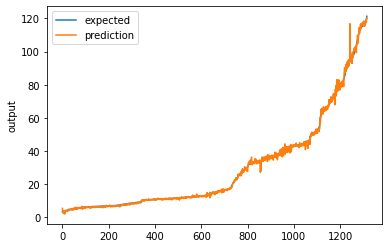

In [21]:
start_time = datetime.now()

#checkpoint to save best model
filepath_savemodel = os.path.join(dnn_path,"p2_BiDirect_LSTM_v1.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)

print("Model training begins.....")
for i in range(5):
  model = Sequential()
  model.add(Bidirectional(LSTM(100, activation="relu", input_shape=ip_size)))
  model.add(Dense(50))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam')

  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=4, verbose=0, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor,checkpoint],verbose=0, epochs=100)  

time_elapsed = datetime.now() - start_time
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

print("load model....")
model.load_weights(filepath_savemodel)

print("Model prediction begins.....")
pred = model.predict(x_test)

model.summary()
print()
print()
# model performance evaluation
graphplot.regression_performance_metrics(y_test,pred,"LSTM - Single Bidirectional layer", parameters)
graphplot.chart_regression(pred.flatten(),y_test)

#### **CASE 2: Multiple Bidirectional LSTM layer**

In [24]:
layers={'Bidirectional-LSTM': [128, 64] }
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer, 'dropout': dropout}

print(parameters)

{'layers': {'Bidirectional-LSTM': [128, 64]}, 'activation': ['ReLu'], 'optimizer': ['adam'], 'dropout': {'regular': 0.1, 'recurrent': 0.1}}


Model training begins.....
Time elapsed (hh:mm:ss.ms) 0:06:25.613389
load model....
Model prediction begins.....
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_42 (Bidirectio (None, 7, 256)            137216    
_________________________________________________________________
bidirectional_43 (Bidirectio (None, 128)               164352    
_________________________________________________________________
dense_68 (Dense)             (None, 50)                6450      
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 51        
Total params: 308,069
Trainable params: 308,069
Non-trainable params: 0
_________________________________________________________________


-------- Performance Evalutation for  LSTM - Multiple Bidirectional layers  --------
-------- Parameters:  {'layers': {'Bidirectio

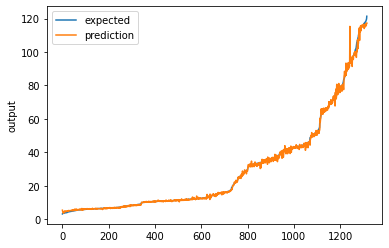

In [23]:
start_time = datetime.now()

#checkpoint to save best model
filepath_savemodel = os.path.join(dnn_path,"p2_BiDirect_LSTM_v2.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)

print("Model training begins.....")
for i in range(3):
  model = Sequential()
  model.add(Bidirectional(LSTM(128, dropout=0.1, recurrent_dropout=0.1, input_shape=ip_size, return_sequences = True)))
  model.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.1)))
  model.add(Dense(50))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam')

  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=4, verbose=0, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor,checkpoint],verbose=0, epochs=100)  

time_elapsed = datetime.now() - start_time
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

print("load model....")
model.load_weights(filepath_savemodel)

print("Model prediction begins.....")
pred = model.predict(x_test)

model.summary()
print()
print()
# model performance evaluation
graphplot.regression_performance_metrics(y_test,pred,"LSTM - Multiple Bidirectional layers", parameters)
graphplot.chart_regression(pred.flatten(),y_test)

#### **CASE 3: With Custom Backward layer**

In [16]:
layers={'Bidirectional-LSTM': {'forward layer':128 , 'backward layer': 64} }
dropout= {'regular': 0.1, 'recurrent': 0.1}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer, 'dropout': dropout}

print(parameters)

{'layers': {'Bidirectional-LSTM': {'forward layer': 128, 'backward layer': 64}}, 'activation': ['ReLu'], 'optimizer': ['adam'], 'dropout': {'regular': 0.1, 'recurrent': 0.1}}


Model training begins.....
Time elapsed (hh:mm:ss.ms) 0:01:30.527718
load model....
Model prediction begins.....
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_27 (Bidirectio (None, 192)               86528     
_________________________________________________________________
dense_42 (Dense)             (None, 64)                12352     
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 65        
Total params: 98,945
Trainable params: 98,945
Non-trainable params: 0
_________________________________________________________________


[11.6125 17.0075 33.865  81.43   16.5025] [[11.253584]
 [16.416267]
 [34.394066]
 [82.59816 ]
 [15.608211]]
-------- Performance Evalutation for  LSTM - Multiple Bidirectional layers  --------
-------- Parameters:  {'layers': {'Bidirectional-LSTM': {'forward layer

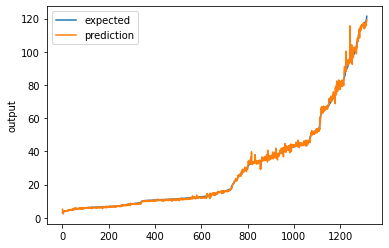

In [17]:
start_time = datetime.now()

#checkpoint to save best model
filepath_savemodel = os.path.join(dnn_path,"p2_BiDirect_LSTM_v3.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)

print("Model training begins.....")
for i in range(3):
  model = Sequential()
  # defining backward and forward layers
  forward_layer = LSTM(128, activation="relu", dropout=0.1, recurrent_dropout=0.1)
  backward_layer = LSTM(64, activation="relu", dropout=0.1, recurrent_dropout=0.1, go_backwards=True)

  model.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=ip_size, merge_mode="concat"))
  model.add(Dense(64))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam')

  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=4, verbose=0, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor,checkpoint],verbose=0, epochs=100)  

time_elapsed = datetime.now() - start_time
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

print("load model....")
model.load_weights(filepath_savemodel)

print("Model prediction begins.....")
pred = model.predict(x_test)

model.summary()
print()
print()

print(y_test[0:5],pred[0:5])
np.argmax(pred, axis =0)
# model performance evaluation
graphplot.regression_performance_metrics(y_test,pred,"LSTM - Multiple Bidirectional layers", parameters)
graphplot.chart_regression(pred.flatten(),y_test)